本文基于前两篇的搭建 Jekyll 的基础上，向博客添加能够方便地撰写科学计算内容的功能，主要是通过 Jupyter Notebook 将 ipynb 文件转换为 Markdown 文件，实现方便地插入 Python/R 的代码及其图像。

该功能在 Jekyll 中并没有原生支持，因此我针对个人使用环境（Windows 平台）编写了命令行脚本，来帮助我完成这一系列自动化工作。

## Python 例子

由于在 Jupyter Notebook 中，一篇文章只能是单内核的（不能同时使用 Python 和 R），因此这里只演示 Python 代码的部分。如果需要显示两种代码，应当另外新建基于另一种代码内核的 ipynb 文件。

此例基于 matplotlib. 语法 Python 3.

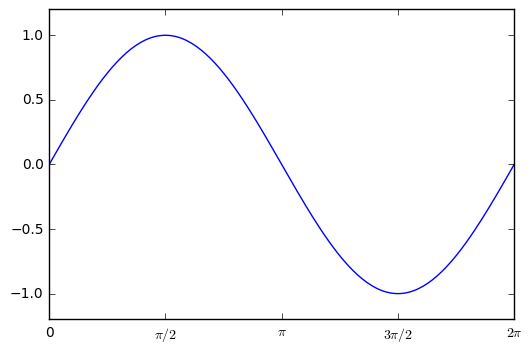

In [1]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(0, 2 * np.pi, 200)
y = np.sin(x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xticks(np.arange(0, 3 * np.pi, np.pi / 2))
ax.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])

plt.axis([0, 2 * np.pi, -1.2, 1.2])
plt.show()

## 实现原理

Jupyer 支持将 ipynb 转为 Markdown 文件，步骤是：

1. 在 ipynb 文件所在文件夹，Shift + 鼠标右键呼出命令行，输入：`Jupyter nbconvert -- to markdown filename.ipynb`，其中 *filename* 请自行根据文件名替换。  
2. 自动生成的文件：
    - 生成一个名为 *filename*\_files 文件夹，存放 ipynb 生成的图片；  
    - 生成同名的 *filename*.md 文件，图片以如下形式链接（以本文为例）：

```
![png](data-science-support-blog-skills_files/data-science-support-blog-skills_1_0.png)
```

因此我们要做的事情就很简单了：

1. 在博客下新建一个名为 ipynb 的文件夹，以后 Jupyter Notebook 文件都放在里面；  
2. 在主文件夹（ipynb 文件夹的上级）下，建立一个 python 文件 \_to-ipynb.py，用于转换。具体代码见下一节。
3. 将 ipynb 文件夹下不需要进行版本控制的内容添加到 .gitignore 文件中。

以后每次写完 ipynb ，用 \_to-ipynb.py 脚本运行一遍即可。对应的图片会自动归档到 `assets/ipynb-images` 目录下，并修复转换好的 markdown 文件中的图片链接。

## \_to-ipynb.py 文件内容

**~ 下载链接在此：[点我](https://github.com/wklchris/wklchris.github.io/blob/master/_to-ipynb.py)**

首先是读取时间（作为博客文件名的一部分），比如 1900-01-30. 然后是读取当前文件位置。用户只需要输入 ipynb 文件的名称（比如 Data-science-support-blog-skills），最好是连字符支持的——因为这将直接在 \_posts 文件夹下生成形如 1900-01-30-Data-science-support-blog-skills.md 文件。

```python
import os, re
import shutil
import datetime

today = datetime.datetime.today()
today = '{}-{:0>2d}-{:0>2d}'.format(today.year, today.month, today.day)
fname = input("Input the file name (DO NOT include '.ipynb'):")

thepath = os.getcwd()
ipynb_path = os.path.join(thepath, 'ipynb')
ipynb_image_path = os.path.join(ipynb_path, r'{}_files'.format(fname))
destination_path = os.path.join(thepath, r'assets/ipynb-images')
post_path = os.path.join(thepath, r'_posts/{}.md').format(today + '-' + fname)
```

其中 {:0>2d} 是强迫症患者用来规范文件名的。月、日不是两位数看着不舒服。

这一段的作用是将 ipynb 文件转为 Markdown 格式，是调用 Windows 命令行实现的。之后将产生的 md 文件移动到 \_posts 文件夹，并重命名。

```python
# Convert ipynb to markdown; 
os.system('jupyter nbconvert --to markdown ipynb/{}.ipynb'.format(fname))
# Move it to "/_posts" and renameit
shutil.move(os.path.join(ipynb_path, '{}.md'.format(fname)), 
            os.path.join(thepath, r'_posts/{}.md').format(fname))
if os.path.isfile(post_path):
    os.remove(post_path)
os.rename(os.path.join(thepath, r'_posts/{}.md').format(fname), post_path)
```

然后，将原来 ipynb 文件夹下的图片文件夹也移动到新的位置： assets/ipynb-images. 随后就可以把原图片文件夹删掉了。

```python
# Move the images under "/ipynb/<fname>_files" to "/assets/ipynb-images"
def moveallfiles(origindir, destinationdir):
    for file in os.listdir(origindir):
        originfile = os.path.join(origindir, file)
        destinationfile = os.path.join(destinationdir, file)
        # If it exists, then delete it and then conduct the movement
        if os.path.isfile(destinationfile):
            os.remove(destinationfile)
        shutil.move(originfile, destinationfile)

moveallfiles(ipynb_image_path, destination_path)
# Delete the origin image path
shutil.rmtree(ipynb_image_path)
```

然后是字符串替换，完成图片链接的修复，并加上 Jekyll 支持的文件头。**每次只需更改文件头即可应用于下一个 ipynb 文件。**

```python
# Replace the image link strings
headstr  = '---\n'
headstr += 'layout: post\n'
headstr += 'title: 怎样用 Github Pages 建立博客（3. 绘图/科学计算）\n'
headstr += 'category: Jekyll\n'
headstr += 'tag: 搭建博客\n'
headstr += '---\n\n'

with open(post_path, 'r', encoding='utf8') as f:
    fstr = f.read()

fstr = re.compile(r'{}_files'.format(fname)).sub(
       r'https://wklchris.github.io/assets/ipynb-images', fstr)
fstr = headstr + fstr

os.remove(post_path)
with open(post_path, 'w', encoding='utf8') as f:
    f.write(fstr)
```

**2017年1月18日更新：**从 ipynb 转到 markdown 时，如 R 中 dataframe 显示格式的表格都会变成 HTML 代码，且不能正常显示于博客中。因此我添加了一部分粗糙的正则表达式代码。而且诡异的是 `re.compile('.', re.DOTALL)` 在我这里怎么也不能匹配 `\n`，所以只好用 `[\s\S]` 代替。

```python
# Convert HTML table to markdown table
def transfertable(tablehtml):

<...略...>

for table in tablehtmllst:
    fstr = re.compile(table).sub(transfertable(table), fstr)
```